Import Python packages.

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime
from os.path import exists
from os import remove

## Load netCDF files
Loading a netCDF file which contains the averaged monthly temperature and another netCDF file which contains the precipitation sum for a month as an `xarray.DataArray`.

In [2]:
# Open the netCDF files
study_date = datetime(2014,4,1)

# Precipitation
m = study_date.strftime("%m")
y_m_d = study_date.strftime("%Y%m%d")
prec_file_path = f"/media/jtrvz/1tb/drought_data/precipitation/nasa_gpm/Global/monthly/netcdf/avg/3B-MO.MS.MRG.3IMERG.{y_m_d}-S000000-E235959.{m}.V07B.HDF5.nc4"

# Temperature
y_m = study_date.strftime("%Y%m")
temp_file_path = f"/media/jtrvz/1tb/drought_data/temperature/era5/Global/monthly/netcdf/avg/t2m_{y_m}.nc"

In [3]:
prec_ds = xr.open_dataset(prec_file_path)
temp_ds = xr.open_dataset(temp_file_path)
temp_ds = temp_ds.rename({"latitude": "lat", "longitude": "lon"})

In [4]:
print(prec_ds.coords)
print(temp_ds.coords)

Coordinates:
  * lat      (lat) float32 7kB -89.95 -89.85 -89.75 -89.65 ... 89.75 89.85 89.95
  * latv     (latv) int32 8B 0 1
  * lon      (lon) float32 14kB -179.9 -179.9 -179.8 ... 179.8 179.8 179.9
  * lonv     (lonv) int32 8B 0 1
  * nv       (nv) int32 8B 0 1
  * time     (time) object 8B 2014-04-01 00:00:00
Coordinates:
  * time     (time) datetime64[ns] 8B 2014-04-01
  * lon      (lon) float32 14kB 0.0 0.1 0.2 0.3 0.4 ... 359.6 359.7 359.8 359.9
  * lat      (lat) float32 7kB 90.0 89.9 89.8 89.7 ... -89.7 -89.8 -89.9 -90.0
  * expver   (expver) int32 8B 1 5


In the following `precipitation` plot you can see that the longitude and latitude are switched. This is something we need to fix in the preprocessing.


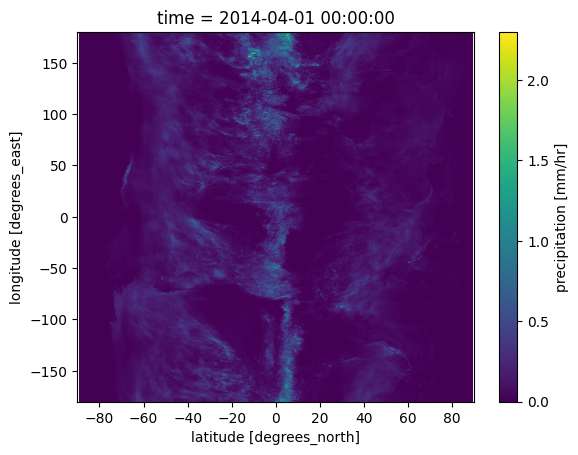

In [5]:
# Show precipitation plot
prec_ds["precipitation"].plot()

The following `temperature` dataset looks uncommon, too. We want to have America on the left, Africa in the center and Eurasia + Australia on the right side of the coordinate system, like we are used to it.

The `expver` dimension needs to be selected because it shows the data product type.

At the moment, the `expver` dimension is not important to us, but it is helpful if you want to find out which ERA5-Land data product is used.

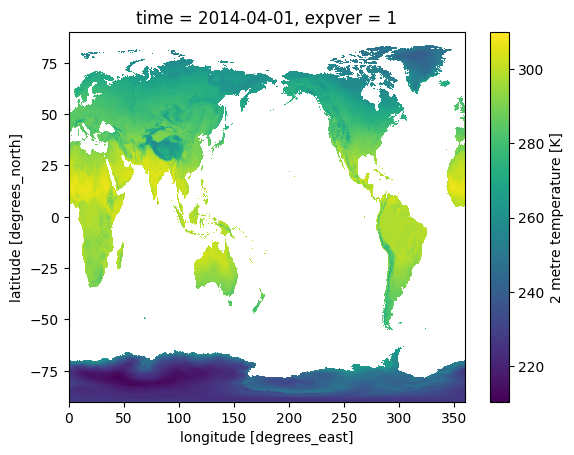

In [6]:
# Show temperature plot
temp_ds_plot = temp_ds["t2m"].isel(expver=0)
temp_ds_plot.plot()

## Data preprocessing

In [7]:
def save_as_nc(dataset, file_path):
    """ Stores xarray.DataArray as netCDF file at file path."""
    if exists(file_path):
        remove(file_path)
        print(f"Removed '{file_path}'")

    dataset.to_netcdf(file_path)
    print(f"Saved '{file_path}'")

### Preprocessing: Precipitation dataset

In [8]:
# Rearrange the dimensions of the precipitation xarray.DataArray
prec_ds = prec_ds.transpose('time', 'lat', 'lon', 'latv', 'lonv', 'nv')
prec_ds

<xarray.Dataset> Size: 130MB
Dimensions:                         (time: 1, lon: 3600, lat: 1800, latv: 2,
                                     nv: 2, lonv: 2)
Coordinates:
  * lat                             (lat) float32 7kB -89.95 -89.85 ... 89.95
  * latv                            (latv) int32 8B 0 1
  * lon                             (lon) float32 14kB -179.9 -179.9 ... 179.9
  * lonv                            (lonv) int32 8B 0 1
  * nv                              (nv) int32 8B 0 1
  * time                            (time) object 8B 2014-04-01 00:00:00
Data variables:
    precipitationQualityIndex       (time, lat, lon) float32 26MB ...
    gaugeRelativeWeighting          (time, lat, lon) float32 26MB ...
    lat_bnds                        (lat, latv) float32 14kB ...
    precipitation                   (time, lat, lon) float32 26MB ...
    probabilityLiquidPrecipitation  (time, lat, lon) float32 26MB ...
    randomError                     (time, lat, lon) float32 26MB ...
    time_bnds                       (time, nv) object 16B ...
    lon_bnds                        (lon, lonv) float32 29kB ...
Attributes:
    FileHeader:                      DOI=10.5067/GPM/IMERG/3B-MONTH/07;\nDOIa...
    FileInfo:                        DataFormatVersion=7e;\nTKCodeBuildVersio...
    Grid.GridHeader:                 BinMethod=ARITHMETIC_MEAN;\nRegistration...
    Grid.fullnamepath:               /Grid
    DODS_EXTRA.Unlimited_Dimension:  time
    history:                         2024-02-20 12:16:37 GMT Hyrax-1.16.3 htt...

In [9]:
# Current datetime used for file name's suffix
dt = datetime.now()
dt_str = dt.strftime("%Y%m%d_%H%M%S")

In [10]:
# Save precipitation DataArray as netCDF file
file_path = f"output/prec_global_{dt_str}.nc"
save_as_nc(prec_ds, file_path)

Saved 'output/prec_global_20240307_155836.nc'


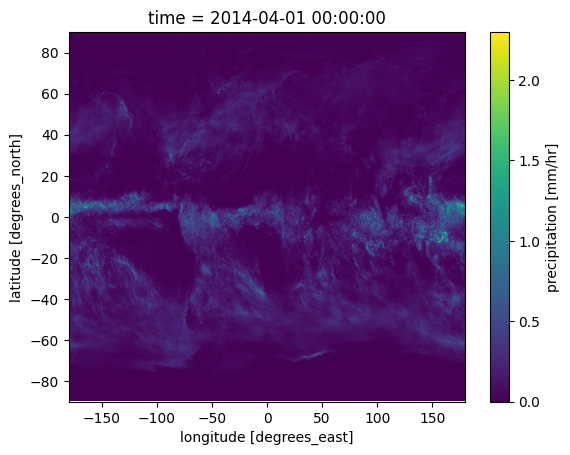

In [11]:
prec_ds["precipitation"].plot()

### Preprocessing: Temperature dataset
The longitude of the **temperature netCDF file** has the range `0.00-180.00` which is why we convert the longitude to the range `-180.00-180.00`.

In [12]:
# Check if longitude conversion is needed
if (temp_ds.lon >= 180).any():
    print("Longitude conversion...")
    # Convert longitude coordinates from 0-360 to -180 to 180
    temp_ds.coords['lon'] = (temp_ds.coords['lon'] + 180) % 360 - 180
    temp_ds = temp_ds.sortby("lon")
    temp_ds = temp_ds.sortby("lat")

Longitude conversion...


In [13]:
# Show temperature DataArray
temp_ds

<xarray.Dataset> Size: 52MB
Dimensions:  (time: 1, lat: 1801, expver: 2, lon: 3600)
Coordinates:
  * time     (time) datetime64[ns] 8B 2014-04-01
  * lat      (lat) float32 7kB -90.0 -89.9 -89.8 -89.7 ... 89.7 89.8 89.9 90.0
  * expver   (expver) int32 8B 1 5
  * lon      (lon) float32 14kB -180.0 -179.9 -179.8 ... 179.7 179.8 179.9
Data variables:
    t2m      (time, expver, lat, lon) float32 52MB ...
Attributes:
    CDI:          Climate Data Interface version 2.0.4 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Wed Feb 21 17:15:59 2024: cdo splityearmon data.nc t2m_\n20...
    CDO:          Climate Data Operators version 2.0.4 (https://mpimet.mpg.de...

If the `xarray.DataSets` will be modified we will save the datasets to the `output/` directory using the following function.

In [14]:
# Save temperature DataArray as netCDF file
file_path = f"output/temp_global_{dt_str}.nc"
save_as_nc(temp_ds, file_path)

Saved 'output/temp_global_20240307_155836.nc'


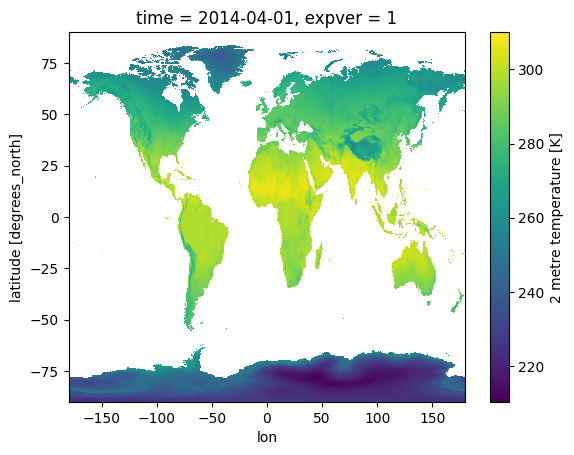

In [15]:
# Show modified temperature diagram
temp_ds_plot = temp_ds["t2m"].isel(expver=0)
temp_ds_plot.plot()

## Select Germany as study area
For this study we use the latitude and longtitude bounds of the European country Germany.

**Lat:** 47.0, 55.0\
**Lon:** 5.5, 15.0

In [16]:
# Spatial subset for Germany (Europe)
lat_bounds = [47.0, 55.0]
lon_bounds = [5.5, 15.0]

In [17]:
# Select the data for Germany
precip_germany = prec_ds.sel(lat=slice(*lat_bounds), lon=slice(*lon_bounds))
temp_germany = temp_ds.sel(lat=slice(*lat_bounds), lon=slice(*lon_bounds))

In [18]:
# Save netCDF files for the region Germany
save_as_nc(precip_germany, file_path=f"output/prec_germany_{dt_str}.nc")
save_as_nc(temp_germany, file_path=f"output/temp_germany_{dt_str}.nc")

Saved 'output/prec_germany_20240307_155836.nc'
Saved 'output/temp_germany_20240307_155836.nc'


## Calculate PET

In [19]:
def calculate_thornthwaite_pet(temp):
    """
    Calculate PET using the Thornthwaite equation.
    temp: Monthly average temperature in Celsius.
    """
    # Convert temperature to Celsius
    temp_celsius = temp - 273.15

    # Calculate I (heat index)
    # I = ((temp_celsius / 5.0) ** 1.514).sum('time')
    I = ((temp_celsius / 5.0) ** 1.514).groupby("time.month").sum('time')

    # Calculate a
    # a = (6.75e-7 * I**3) - (7.71e-5 * I**2) + (1.79e-2 * I) + 0.49
    a = (6.75e-07) * I**3 - (7.71e-05) * I**2 + (1.792e-02) * I + 0.49239
    # a = 0.49 + 0.0179 * temp_celsius - 0.0000771 * temp_celsius**2 + 0.000000675 * temp_celsius**3
    
    # Days in month
    days_in_month = temp_celsius.time.dt.days_in_month

    # Calculate PET
    # pet = 16 * ((10 * temp_celsius / I) ** a)
    pet_mm = (16 * (10 * temp_celsius / I)**a) * (days_in_month / 12)
    return pet_mm

In [20]:
# Calculate PET for Germany
pet_germany = calculate_thornthwaite_pet(temp_germany['t2m'])
pet_germany

<xarray.DataArray (time: 1, expver: 2, lat: 81, lon: 96, month: 1)> Size: 124kB
array([[[[[276.56957626],
          [276.50529861],
          [276.39062881],
          ...,
          [286.41714096],
          [283.74916077],
          [280.48686981]],

         [[276.59673691],
          [276.53152466],
          [276.46131516],
          ...,
          [283.38960648],
          [281.96352005],
          [279.78712082]],

         [[276.53152466],
          [276.46316528],
          [276.35145187],
          ...,
...
          ...,
          [         nan],
          [         nan],
          [         nan]],

         [[         nan],
          [         nan],
          [         nan],
          ...,
          [         nan],
          [         nan],
          [         nan]],

         [[         nan],
          [         nan],
          [         nan],
          ...,
          [         nan],
          [         nan],
          [         nan]]]]])
Coordinates:
  * time     (time) datetime64[ns] 8B 2014-04-01
  * lat      (lat) float32 324B 47.0 47.1 47.2 47.3 47.4 ... 54.7 54.8 54.9 55.0
  * expver   (expver) int32 8B 1 5
  * lon      (lon) float32 384B 5.5 5.6 5.7 5.8 5.9 ... 14.6 14.7 14.8 14.9 15.0
  * month    (month) int64 8B 4

In [21]:
# Calculate water balance for Germany
prec = precip_germany['precipitation']
pet_germany = pet_germany.sel(expver=1)
pet_germany = pet_germany.transpose('time', 'lat', 'lon', 'month')

In [22]:
# Convert time to datetime64
pet_germany['time'] = pet_germany['time'].astype('datetime64[ns]')
prec['time'] = prec['time'].astype('datetime64[ns]')

In [23]:
pet_germany = pet_germany.interp(lat=prec.lat, lon=prec.lon, method='linear')
pet_germany

/media/jtrvz/chugchug/Git/drought-detector/venv/lib/python3.10/site-packages/scipy/interpolate/_interpolate.py:710: RuntimeWarning: invalid value encountered in subtract
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/media/jtrvz/chugchug/Git/drought-detector/venv/lib/python3.10/site-packages/scipy/interpolate/_interpolate.py:713: RuntimeWarning: invalid value encountered in add
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


<xarray.DataArray (time: 1, lat: 80, lon: 95, month: 1)> Size: 61kB
array([[[[276.55078627],
         [276.47219313],
         [276.25800133],
         ...,
         [285.93773365],
         [283.87983754],
         [281.49659007]],

        [[276.53074138],
         [276.45186724],
         [276.31553233],
         ...,
         [281.4836584 ],
         [280.98228065],
         [280.6610154 ]],

        [[276.54706553],
         [276.48257408],
         [276.37914181],
         ...,
...
         ...,
         [         nan],
         [         nan],
         [         nan]],

        [[         nan],
         [         nan],
         [         nan],
         ...,
         [         nan],
         [         nan],
         [         nan]],

        [[         nan],
         [         nan],
         [         nan],
         ...,
         [         nan],
         [         nan],
         [         nan]]]])
Coordinates:
    expver   int32 4B 1
  * month    (month) int64 8B 4
  * time     (time) datetime64[ns] 8B 2014-04-01
  * lat      (lat) float32 320B 47.05 47.15 47.25 47.35 ... 54.75 54.85 54.95
  * lon      (lon) float32 380B 5.55 5.65 5.75 5.85 ... 14.65 14.75 14.85 14.95

In [24]:
# Save PET dataset as netCDF file
save_as_nc(pet_germany, file_path=f"output/pet_germany_{dt_str}.nc")

Saved 'output/pet_germany_20240307_155836.nc'


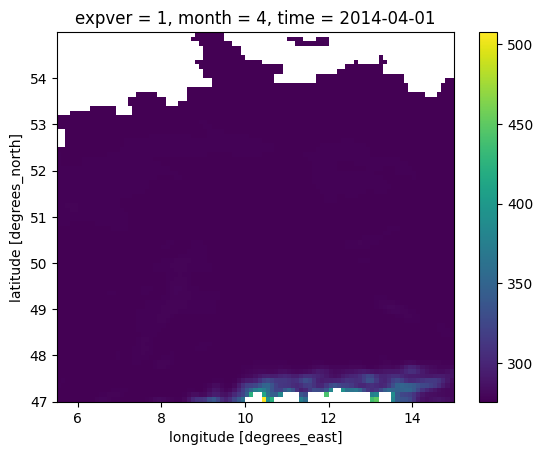

In [25]:
# Show PET as diagram
pet_germany.plot()

In [26]:
print(prec.shape)
print(pet_germany.shape)
print(prec.dims)
print(pet_germany.dims)
print(prec.coords)
print(pet_germany.coords)

(1, 80, 95)
(1, 80, 95, 1)
('time', 'lat', 'lon')
('time', 'lat', 'lon', 'month')
Coordinates:
  * lat      (lat) float32 320B 47.05 47.15 47.25 47.35 ... 54.75 54.85 54.95
  * lon      (lon) float32 380B 5.55 5.65 5.75 5.85 ... 14.65 14.75 14.85 14.95
  * time     (time) datetime64[ns] 8B 2014-04-01
Coordinates:
    expver   int32 4B 1
  * month    (month) int64 8B 4
  * time     (time) datetime64[ns] 8B 2014-04-01
  * lat      (lat) float32 320B 47.05 47.15 47.25 47.35 ... 54.75 54.85 54.95
  * lon      (lon) float32 380B 5.55 5.65 5.75 5.85 ... 14.65 14.75 14.85 14.95


In [27]:
# Calculate water balance
difference = prec - pet_germany
difference

<xarray.DataArray (time: 1, lat: 80, lon: 95, month: 1)> Size: 61kB
array([[[[-276.49678627],
         [-276.41519313],
         [-276.19700132],
         ...,
         [-285.79673365],
         [-283.73883754],
         [-281.35559006]],

        [[-276.48174138],
         [-276.39986724],
         [-276.25953233],
         ...,
         [-281.3436584 ],
         [-280.84228064],
         [-280.52201539]],

        [[-276.50306553],
         [-276.43457408],
         [-276.3281418 ],
         ...,
...
         ...,
         [          nan],
         [          nan],
         [          nan]],

        [[          nan],
         [          nan],
         [          nan],
         ...,
         [          nan],
         [          nan],
         [          nan]],

        [[          nan],
         [          nan],
         [          nan],
         ...,
         [          nan],
         [          nan],
         [          nan]]]])
Coordinates:
  * lat      (lat) float32 320B 47.05 47.15 47.25 47.35 ... 54.75 54.85 54.95
  * lon      (lon) float32 380B 5.55 5.65 5.75 5.85 ... 14.65 14.75 14.85 14.95
  * time     (time) datetime64[ns] 8B 2014-04-01
    expver   int32 4B 1
  * month    (month) int64 8B 4

In [28]:
# Save water balance as netCDF file
save_as_nc(difference, file_path=f"output/water_balance_germany_{dt_str}.nc")

Saved 'output/water_balance_germany_20240307_155836.nc'


In [34]:
difference.values

array([[[[-276.49678627],
         [-276.41519313],
         [-276.19700132],
         ...,
         [-285.79673365],
         [-283.73883754],
         [-281.35559006]],

        [[-276.48174138],
         [-276.39986724],
         [-276.25953233],
         ...,
         [-281.3436584 ],
         [-280.84228064],
         [-280.52201539]],

        [[-276.50306553],
         [-276.43457408],
         [-276.3281418 ],
         ...,
         [-281.51655953],
         [-280.59507045],
         [-280.55690588]],

        ...,

        [[          nan],
         [          nan],
         [          nan],
         ...,
         [          nan],
         [          nan],
         [          nan]],

        [[          nan],
         [          nan],
         [          nan],
         ...,
         [          nan],
         [          nan],
         [          nan]],

        [[          nan],
         [          nan],
         [          nan],
         ...,
         [          nan],
        

In [29]:
from scipy.stats import genlogistic
from scipy.special import ndtri

water_balance_flat = difference.values.flatten()
water_balance_clean = water_balance_flat[np.isfinite(water_balance_flat)]
params = genlogistic.fit(water_balance_clean)

In [30]:
cdf_values = genlogistic.cdf(difference, *params)

/media/jtrvz/chugchug/Git/drought-detector/venv/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:2858: RuntimeWarning: overflow encountered in exp
  Cx = (1+np.exp(-x))**(-c)


In [31]:
spei = xr.DataArray(ndtri(cdf_values), coords=difference.coords, dims=difference.dims)

In [32]:
save_as_nc(spei, file_path=f"output/spei_germany_{dt_str}.nc")

Saved 'output/spei_germany_20240307_155836.nc'


This is the SPEI diagram which shows the SPEI values.
The indices should be interpreted as such:

| Range of Values   | Regime            |
|-------------------|-------------------|
| 2 < SPEI <= MAX     | Extremely Wet     |
| 1.5 < SPEI <= 2.0   | Very Wet          |
| 1.0 < SPEI <=1.5    | Moderately Wet    |
| -1.0 < SPEI <= 1.0  | Normal Conditions |
| -1.5 < SPEI <= -1.0 | Moderately Dry    |
| -2.0 < SPEI <= -1.5 | Very Dry          |
| MIN <= SPEI <= -2.0 | Extremely Dry     |

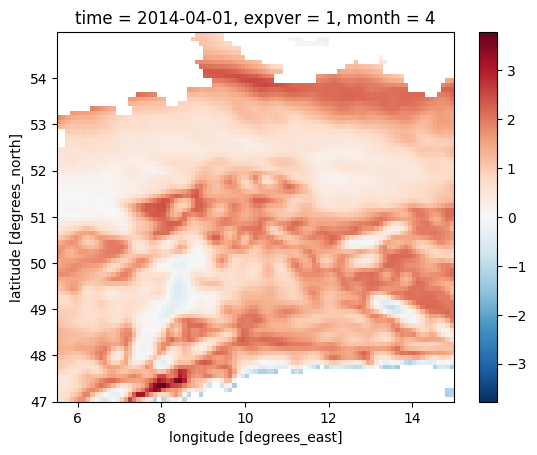

In [33]:
spei.plot()